In [1]:
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split

# Original dataset path
original_dir = "./AnimalsDataset/Animals"
split_base_dir = "./AnimalsDatasetSplit"
classes = ["cats", "dogs", "snakes"]

# Create target directories
for split in ['train', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)


In [2]:
for cls in classes:
    class_dir = os.path.join(original_dir, cls)
    images = os.listdir(class_dir)
    
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(split_base_dir, 'train', cls, img)
        shutil.copy(src, dst)

    for img in val_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(split_base_dir, 'test', cls, img)
        shutil.copy(src, dst)

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "./AnimalsDatasetSplit/train",
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "./AnimalsDatasetSplit/test",
    image_size=(224, 224),
    batch_size=32
)

class_names = train_ds.class_names 
num_classes = len(train_ds.class_names)
num_classes
train_ds

Found 2400 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [5]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Helps prevent overfitting
    tf.keras.layers.Dense(num_classes, activation='softmax')  # For multi-class
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

In [10]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)
print(type(num_classes)) 

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 505ms/step - accuracy: 0.3609 - loss: 1.3179 - val_accuracy: 0.5450 - val_loss: 1.0444
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 484ms/step - accuracy: 0.5127 - loss: 0.9570 - val_accuracy: 0.6550 - val_loss: 0.7380
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 509ms/step - accuracy: 0.6389 - loss: 0.7940 - val_accuracy: 0.6183 - val_loss: 0.8182
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 511ms/step - accuracy: 0.6639 - loss: 0.6920 - val_accuracy: 0.5883 - val_loss: 1.0249
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 494ms/step - accuracy: 0.7173 - loss: 0.6404 - val_accuracy: 0.6783 - val_loss: 0.7491
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 504ms/step - accuracy: 0.7534 - loss: 0.5508 - val_accuracy: 0.6500 - val_loss: 0.8888
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 469ms/step - accuracy: 0.8259 - loss: 0.4074 - val_accuracy: 0.6067 - val_loss: 1.2719
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 473ms/step - accuracy: 0.8675 - loss: 0.3283 - val_accu

In [11]:
loss, accuracy = model.evaluate(test_ds)
print(f"Validation accuracy: {accuracy:.2f}")

from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5803 - loss: 2.0303
Validation accuracy: 0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
              precision    recall  f1-score   support

        cats       0.75      0.36      0.49       200
        dogs       0.55      0.46      0.50      

2025-06-21 22:02:15.795834: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


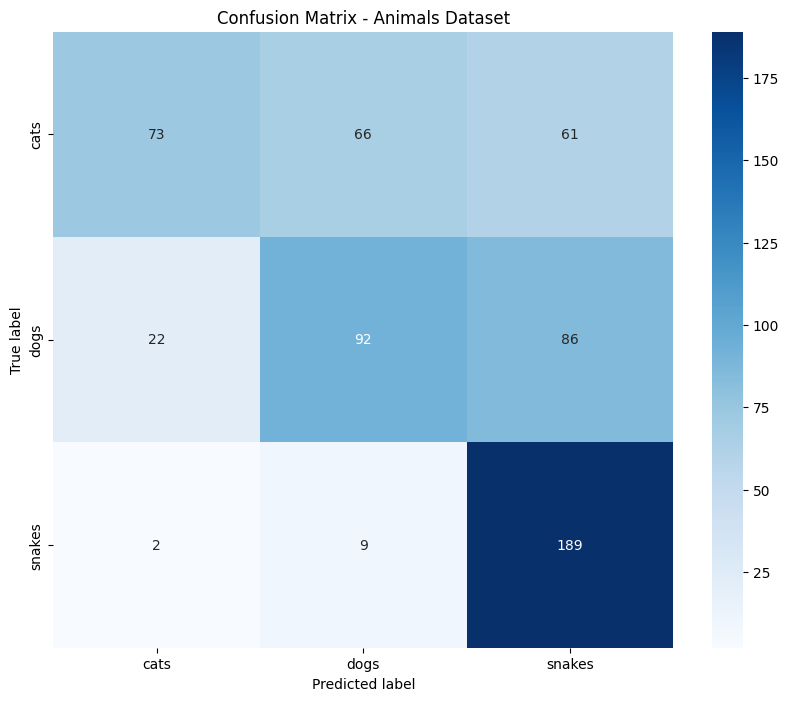

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Animals Dataset')
plt.show()


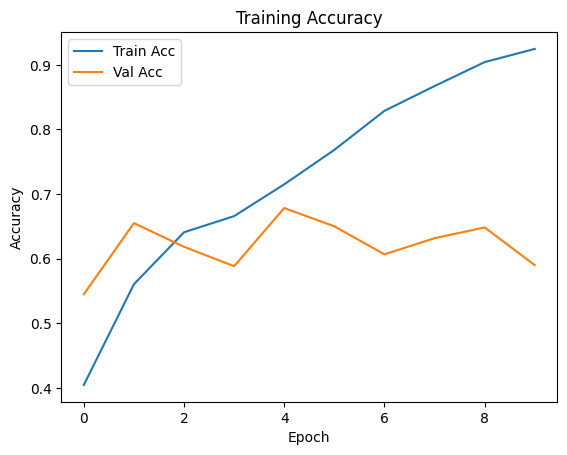

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()


In [13]:
model.export("./animalsClassifierTensor")

INFO:tensorflow:Assets written to: ./animalsClassifierTensor/assets


INFO:tensorflow:Assets written to: ./animalsClassifierTensor/assets


Saved artifact at './animalsClassifierTensor'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13698388176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698388944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698389904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698389136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698390096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698389520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698388560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698390480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698392208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698390672: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./animalsClassifierTensor")

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('animalClassifierTFLite.tflite', 'wb') as f:
  f.write(tflite_model)